In [1]:
import sys
sys.path.append('../../')
import cresthh
from cresthh import anuga
from osgeo import gdal
from glob import glob
from affine import Affine
import geopandas as gpd
from pyproj import Proj, CRS, transform
import os
import json

%matplotlib inline

# Allow inline jshtml animations
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
sys.path.append('/home/ZhiLi/PlotGallory')
from matplotlibconfig import basic
basic()

In [3]:
bounding_polygon= gpd.read_file('../excessive_rain/area/08076700.shp')
# topography_file = 'DEM.tif'
# topography_file= '/home/ZhiLi/CRESTHH/data/precip/imerg20170825S150000.tif'
# Resolution for most of the mesh
base_resolution = 400**2  # m^2
inner_zone_channel= gpd.read_file('../excessive_rain/area/08076700_river.shp')
min_res= 10**2

coords_inner_channel= np.array(inner_zone_channel.boundary[0].coords)

domain = anuga.create_domain_from_regions(
        list(bounding_polygon.exterior[0].coords),
        boundary_tags={'bottom': [0],},
        maximum_triangle_area=base_resolution,
#         interior_regions=[[coords_inner_channel, 10**2]],
        mesh_filename='original_08076700_uni.msh'
        )

In [16]:
len(domain.areas)

5844

In [3]:
domain= anuga.create_domain_from_file('original_08076700.msh')

[]


In [2]:
domain= anuga.create_domain_from_file('/home/ZhiLi/mesher/examples/08076700_new/stream_dem/DEM_10m.mesh')

[]


(29800, 31300)

(5500, 7000)

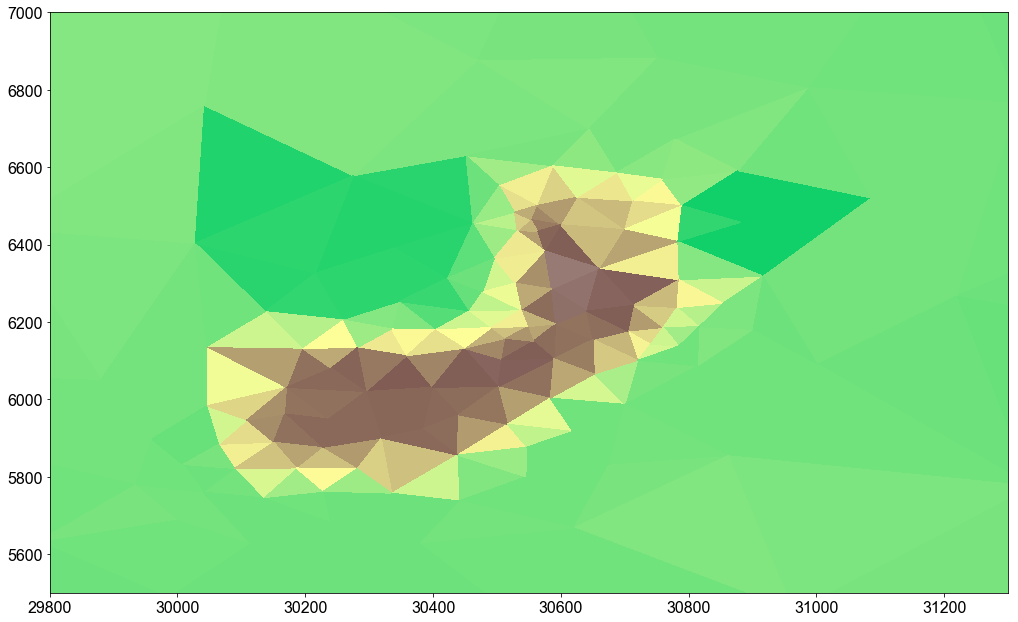

In [26]:
plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='terrain')
plt.xlim([29800, 31300])
plt.ylim([5500, 7000])

Figure files for each frame will be stored in _plot
[]
Figure files for each frame will be stored in _plot
[]
Figure files for each frame will be stored in _plot
[]
Figure files for each frame will be stored in _plot


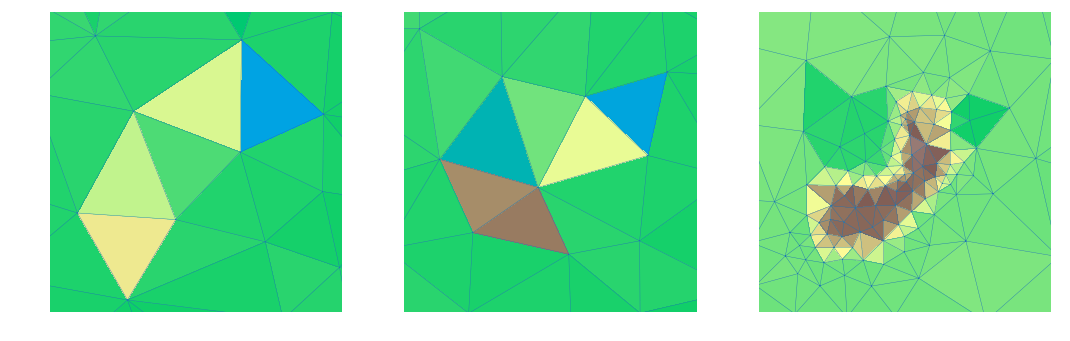

In [27]:
dplotter = anuga.Domain_plotter(domain)  
fig= plt.figure(figsize=(15,5))
ax=fig.add_subplot(131)
domain= anuga.create_domain_from_file('original_08076700_uni.msh')
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
dplotter = anuga.Domain_plotter(domain)
ax.triplot(dplotter.triang, linewidth = 0.4)
ax.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='terrain')

# cbar=plt.colorbar(orientation='horizontal');
# cbar.ax.set_xlabel('DEM (m)')
# plt.frame('on')
ax.axis('off', frameon=0);
# plt.title("Elevation");
# plt.xlim([31500, 33500])
# plt.ylim([-500, 1500])
# plt.xlim([32100, 33600])
# plt.ylim([14200, 15700])
plt.xlim([29800, 31300])
plt.ylim([5500, 7000])
ax=fig.add_subplot(132)
domain= anuga.create_domain_from_file('original_08076700.msh')
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
dplotter = anuga.Domain_plotter(domain)
ax.triplot(dplotter.triang, linewidth = 0.4)
ax.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='terrain')
# plt.xlim([31500, 33500])
# plt.ylim([-500, 1500])
# plt.xlim([32100, 33600])
# plt.ylim([14200, 15700])
plt.xlim([29800, 31300])
plt.ylim([5500, 7000])
ax.axis('off', frameon=0);
ax=fig.add_subplot(133)
domain= anuga.create_domain_from_file('/home/ZhiLi/mesher/examples/08076700_new/stream_dem/DEM_10m.mesh')
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
dplotter = anuga.Domain_plotter(domain)
ax.triplot(dplotter.triang, linewidth = 0.4)
ax.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='terrain')
# plt.xlim([31500, 33500])
# plt.ylim([-500, 1500])
# plt.xlim([32100, 33600])
# plt.ylim([14200, 15700])
plt.xlim([29800, 31300])
plt.ylim([5500, 7000])
ax.axis('off', frameon=0);
plt.tight_layout();

In [28]:
fig.savefig('src/mesh_comppsite3.png', dpi=500)

In [178]:
terrain= gdal.Open('/home/ZhiLi/mesher/examples/08076700_new/DEM_10m.tif').ReadAsArray()
mesher= gdal.Open('/home/ZhiLi/CRESTHH/Examples/calibration/results/mesher_DEM.tif').ReadAsArray()
orig= gdal.Open('/home/ZhiLi/CRESTHH/Examples/calibration/results/orig_DEM.tif').ReadAsArray()
uni= gdal.Open('/home/ZhiLi/CRESTHH/Examples/calibration/results/orig_uni_DEM.tif').ReadAsArray()

In [179]:
terrain[terrain<-1000]=np.nan
mesher[mesher<-1000]=np.nan
orig[orig<-1000]=np.nan
uni[uni<-1000]=np.nan


In [121]:
RMSE= np.nanmean((terrain - mesher)**2)**.5
print('RMSE value equals: %.2f meters'%RMSE)

RMSE value equals: 0.98 meters


In [122]:
RMSE= np.nanmean((terrain - uni)**2)**.5
print('RMSE value equals: %.2f meters'%RMSE)

RMSE value equals: 1.03 meters


In [127]:
RMSE= np.nanmean((terrain[~np.isnan(terrain) & (~np.isnan(orig))] - orig[(~np.isnan(terrain)) & (~np.isnan(orig))])**2)**.5
print('RMSE value equals: %.2f meters'%RMSE)

RMSE value equals: 0.98 meters


In [135]:
import skimage

In [138]:
skimage.__version__

'0.14.5'

In [170]:
from skimage.measure import compare_psnr as psnr
from skimage.measure import compare_mse as mse

In [165]:
mse(terrain[~np.isnan(terrain) & (~np.isnan(orig))], orig[(~np.isnan(terrain)) & (~np.isnan(orig))])**0.5

0.9801553689283484

In [181]:
ssim(terrain[~np.isnan(terrain) & (~np.isnan(orig))], orig[(~np.isnan(terrain)) & (~np.isnan(orig))], win_size=3)

0.7720334236050987

In [164]:
mse(terrain[~np.isnan(terrain) & (~np.isnan(mesher))], mesher[(~np.isnan(terrain)) & (~np.isnan(mesher))])**0.5

0.6053671378405298

In [182]:
ssim(terrain[~np.isnan(terrain) & (~np.isnan(mesher))], mesher[(~np.isnan(terrain)) & (~np.isnan(mesher))], win_size=3)

0.7741125753004935

In [166]:
mse(terrain[~np.isnan(terrain) & (~np.isnan(uni))], uni[(~np.isnan(terrain)) & (~np.isnan(uni))])**0.5

1.0328632134127578

In [183]:
ssim(terrain[~np.isnan(terrain) & (~np.isnan(uni))], uni[(~np.isnan(terrain)) & (~np.isnan(uni))], win_size=3)

0.7692501158351553

In [98]:
geo= terrain.GetGeoTransform()
geo

(250446.108, 9.154628703254007, 0.0, 3324508.3057, 0.0, -9.152864858490538)

In [105]:
geo[0]+terrain.RasterXSize*geo[1]

288144.869

In [106]:
geo[3]+terrain.RasterYSize*geo[-1]

3301223.4175

In [109]:
orig= gdal.Open('/home/ZhiLi/CRESTHH/Examples/calibration/results/orig_DEM.tif')

In [111]:
orig.ReadAsArray().shape

(2544, 4118)

In [6]:
from cresthh.anuga import SWW_plotter

splotter= SWW_plotter('../Sensitivity/temp.sww')
# splotter= SWW_plotter('../simple_infiltration/simple_infiltration_orig_mesh.sww')
xc= splotter.xc+ splotter.xllcorner
yc= splotter.yc+ splotter.yllcorner


Figure files for each frame will be stored in _plot


In [35]:
from affine import Affine

In [62]:
a= Affine.from_gdal(*geo)
icols, irows= ~a * (xc, yc)
icols= icols.astype(int)
irows= irows.astype(int)

In [63]:
elev= terrain.ReadAsArray()[irows, icols]

In [64]:
RMSE= np.nanmean((elev - splotter.elev)**2)
print('RMSE value equals: %.2f meters'%RMSE)

RMSE value equals: 0.24 meters


In [65]:
diff= elev-splotter.elev

In [71]:
(elev - splotter.elev)**2

array([1.7270249e-04, 1.7117461e-03, 3.6234414e-06, ..., 8.0664167e-03,
       3.6033699e-03, 1.3072346e-03], dtype=float32)

In [20]:
(domain.areas).argmin()

8807

In [34]:
domain.areas.shape

(91942,)

In [5]:
domain.quantities['x'].centroid_values[8807]

33825.46106179765

In [21]:
domain.quantities['y'].centroid_values[8807]

3796.282682200273

In [36]:
domain= anuga.create_domain_from_file('/home/ZhiLi/mesher/examples/flow_accumulation/flow_accumulation/DEM_10m.mesh')

[]


In [7]:
topography_file = '/hydros/ZhiLi/demHouston033s_NAm83.tif'
# topography_file = '/hydros/ZhiLi/DEM_08076700.tif'
# topography_file='/home/ZhiLi/mesher/examples/flow_accumulation/flow_accumulation/DEM_10m/DEM_10m_4326.tif'

Figure files for each frame will be stored in _plot


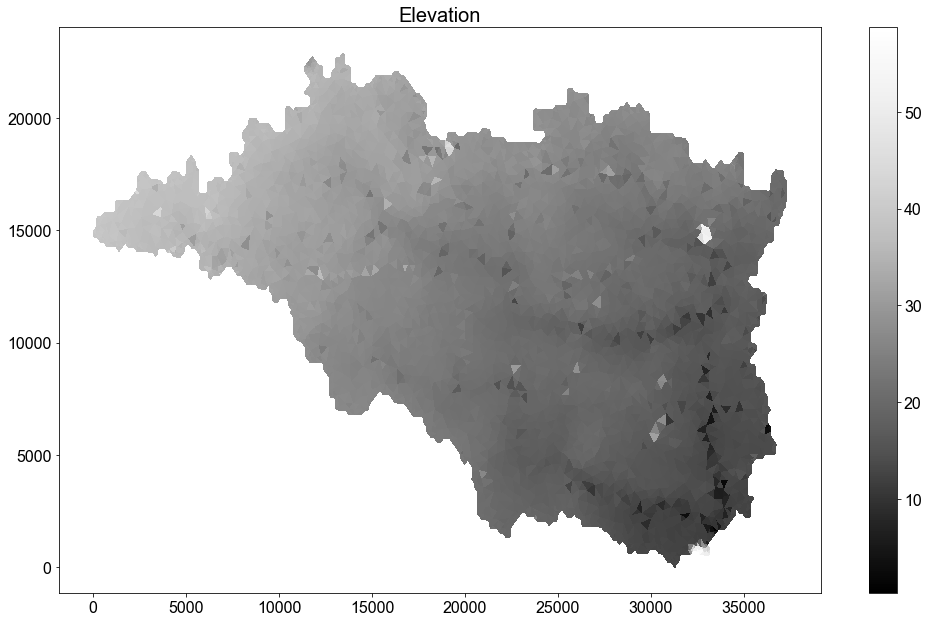

In [11]:
start= '20170825000000'
end= '20170825010000'
domain.set_proj("+proj=utm +zone=15, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")
domain.set_quantity('elevation', filename=topography_file, location='centroids') # Use function for elevation
domain.set_quantity('friction', filename='/home/ZhiLi/CRESTHH/data/Texas_friction/manningn.tif', location='centroids')
domain.quantities['friction'].centroid_values[:]*=0
domain.set_quantity('stage', expression='elevation', location='centroids')         # Dry Bed 
domain.set_quantity('SM', 0.8, location='centroids')
domain.set_quantity('Ksat', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/ksat.tif', location='centroids')
domain.set_quantity('WM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/wm_10m.tif', location='centroids')
domain.set_quantity('B', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/b_10m.tif', location='centroids')
domain.set_quantity('IM', filename='/hydros/MengyuChen/Summer/New/CREST_parameters/crest_param/im.tif', location='centroids')
domain.set_quantity('KE', 0.89, location='centroids')
domain.set_coupled(True)

domain.set_evap_dir('/home/ZhiLi/CRESTHH/data/evap', pattern='cov_et17%m%d.asc.tif', freq='1D')
# domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/precip',pattern='nimerg%Y%m%dS%H%M%S.tif', freq='1H')
domain.set_precip_dir('/home/ZhiLi/CRESTHH/data/synthetic_rainfall',pattern='PrecipRate_00.00_%Y%m%d-%H%M00.grib2-var0-z0.tif', freq='2M')
domain.set_timestamp(start, format='%Y%m%d%H%M%S')
domain.set_time_interval('2M')
domain.set_name('coupled_10m_modified_mesh')
total_seconds= (pd.to_datetime(end) - pd.to_datetime(start)).total_seconds()
dplotter = anuga.Domain_plotter(domain)
plt.tripcolor(dplotter.triang, 
              facecolors = dplotter.elev, 
              cmap='Greys_r')

plt.colorbar();
plt.title("Elevation");

In [5]:
Br = anuga.Reflective_boundary(domain)
Bt = anuga.Transmissive_boundary(domain)
Bi = anuga.Dirichlet_boundary([0, 0, 0]) 

domain.set_boundary({'bottom':   Bt,
                     'interior': Br,
                     'exterior': Bi})

In [6]:
# Rain = anuga.Quantity(domain, name='Rain')
# ET= anuga.Quantity(domain, name='ET')
# forcing_op= anuga.Rate_operator(domain, rate=Rain+ET)
# rain_op = anuga.Rate_operator(domain, rate = Rain)
# et_op = anuga.Rate_operator(domain, rate= Evap)
# Rain= anuga.Rate_operator(domain, rate=lambda t: 5 if t<5 else 10)
for i,t in enumerate(domain.evolve(yieldstep=120, duration=3600*3)):
#     current_rain_file = sorted(glob(external_dir+'/*.tif'))[i]
#     print(current_rain_file)
#     Rain.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     ET.set_values_from_utm_grid_file(current_rain_file, location='centroids')
#     dplotter.plot_depth_frame()
    dplotter.save_depth_frame(vmin=0, vmax=30)

    domain.print_timestepping_statistics(track_speeds=False)

    rain= domain.get_quantity('P').centroid_values
    ET= domain.get_quantity('ET').centroid_values
    exc_rain= domain.get_quantity('excess_rain').centroid_values
    soil= domain.get_quantity('SM').centroid_values
    print 'rain: %f; ET: %f; excessive_rain: %f; soil: %f'%(rain[100]*1000, ET[100]*1000, exc_rain[100]*1000, soil[100]*100)
    stage = domain.get_quantity('stage')
    print 'friction: ',domain.get_quantity('friction').centroid_values[100]
    elev  = domain.get_quantity('elevation')
    height = stage - elev
    print 'integral = ', height.get_integral()    
# Read in the png files stored during the evolve loop
dplotter.make_depth_animation()

Time = 2017-08-25 00:00:00, steps=0 (45s)
rain: 0.000000; ET: 0.000000; excessive_rain: 0.000000; soil: 80.000000
friction:  0.0
integral =  0.0
Time = 2017-08-25 00:02:00, delta t = 1000.00000000, steps=1 (5s)
rain: 0.027778; ET: 0.000016; excessive_rain: 0.000000; soil: 80.000000
friction:  0.0
integral =  0.0
Time = 2017-08-25 00:04:00, delta t = 1000.00000000, steps=1 (6s)
rain: 0.027778; ET: 0.000016; excessive_rain: 0.018919; soil: 83.487634
friction:  0.0
integral =  4315489.629600227
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww could not be opened - trying step 360.0 again
Warning (store_timestep): File ./coupled_10m_modified_mesh.sww coul

DataFileNotOpenError: File ./coupled_10m_modified_mesh.sww could not be opened for append

rain

from cresthh.anuga import SWW_plotter

splotter= SWW_plotter('coupled_10m_modified_mesh.sww')

plt.figure(figsize=(15,8))
# splotter.triang.set_mask(splotter.depth.mean(axis=0) > 0.1)
# plt.tripcolor(splotter.triang,
#               facecolors=splotter.elev,
#               cmap='gray')
splotter.triang.set_mask(splotter.depth.mean(axis=0) <= 0.1)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.depth).mean(axis=0),
              cmap='Blues',
             vmin=0.1,
             vmax=2)
plt.colorbar()

plt.figure(figsize=(15,8))
splotter.triang.set_mask(splotter.speed.max(axis=0) > 0.1)
plt.tripcolor(splotter.triang,
              facecolors=splotter.elev,
              cmap='viridis')
splotter.triang.set_mask(splotter.speed.max(axis=0) <= 0.1)
plt.tripcolor(splotter.triang, 
              facecolors=(splotter.speed).max(axis=0),
              cmap='jet',
             vmin=0,
             vmax=2)
plt.colorbar()